In [1]:
from allensdk.brain_observatory.behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path
from scipy.signal import butter
from copy import deepcopy
output_dir = "C:/Users/Jerry/Downloads/vbn_s3_cache"
cache = VisualBehaviorNeuropixelsProjectCache.from_s3_cache(cache_dir=output_dir)

In [2]:
probes = cache.get_probe_table() # type: ignore
valid_lfp = probes[probes['has_lfp_data']]

print('Fraction of insertions with valid LFP: ', len(valid_lfp)/len(probes))

Fraction of insertions with valid LFP:  0.9602209944751381


In [3]:
session_id = probes.loc[1064735073]['ecephys_session_id']
session = cache.get_ecephys_session(ecephys_session_id=session_id) # type: ignore
lfp = session.get_lfp(1064735073)
lfp

<xarray.DataArray 'LFP' (time: 11924764, channel: 96)>
array([[ 4.53374996e-05,  3.96824980e-05,  3.22724991e-05, ...,
        -1.20899995e-05, -3.90000014e-06, -2.92499999e-06],
       [ 4.01699981e-05,  1.89149996e-05,  4.58249997e-06, ...,
        -1.80374991e-05,  7.50749996e-06,  1.06275002e-05],
       [ 1.52100001e-05, -1.59899992e-05, -1.88174999e-05, ...,
        -8.96999973e-06,  4.38749976e-06,  1.13099995e-05],
       ...,
       [ 4.88474980e-05,  5.40149995e-05,  1.55024991e-05, ...,
        -1.19924998e-05, -2.93475005e-05,  2.92499999e-06],
       [ 6.05474997e-05,  6.00599997e-05,  2.77875006e-05, ...,
        -1.04324999e-05, -2.07675002e-05,  2.73000001e-06],
       [ 4.21199984e-05,  4.96274988e-05,  2.61299992e-05, ...,
        -8.77499951e-06, -1.57949999e-05,  3.89999997e-07]], dtype=float32)
Coordinates:
  * time     (time) float64 4.97 4.971 4.972 ... 9.545e+03 9.545e+03 9.545e+03
  * channel  (channel) int64 1066253838 1066253842 ... 1066254228 1066254232

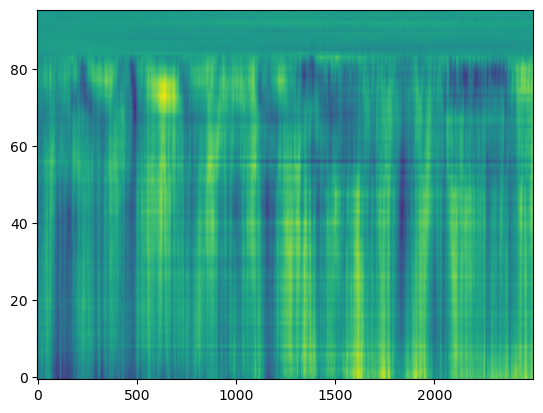

In [4]:
lfp_slice = lfp.sel(time=slice(100,102))
plt.imshow(lfp_slice.T, aspect='auto',origin='lower', cmap='viridis')

In [18]:
lfp_copy = deepcopy(lfp_slice)
result = butter(N=3, Wn=[3, 8], fs=1500, btype='bandpass', output='ba')
print(result)

(array([ 1.12470201e-06,  0.00000000e+00, -3.37410604e-06,  0.00000000e+00,
        3.37410604e-06,  0.00000000e+00, -1.12470201e-06]), array([  1.        ,  -5.95685837,  14.78645446, -19.57718879,
        14.58142424,  -5.79280808,   0.95897654]))


In [23]:
single = lfp_copy.T[0]
print(single)

<xarray.DataArray 'LFP' (time: 2500)>
array([-0.00019744, -0.00017365, -0.00015171, ...,  0.00019422,
        0.00019393,  0.00014976], dtype=float32)
Coordinates:
  * time     (time) float64 100.0 100.0 100.0 100.0 ... 102.0 102.0 102.0 102.0
    channel  int64 1066253838


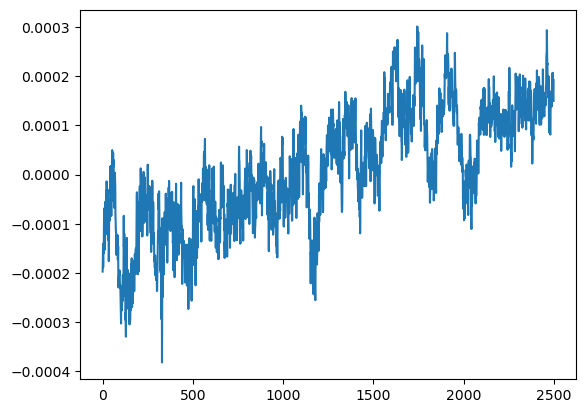

In [24]:
plt.plot(single)

In [19]:
stim_presentations = session.stimulus_presentations
flashes = stim_presentations[stim_presentations['stimulus_name'].str.contains('flash')]
presentation_times = flashes.start_time.values
presentation_ids = flashes.index.values

In [20]:
def align_lfp(lfp, trial_window, alignment_times, trial_ids = None):
    '''
    Aligns the LFP data array to experiment times of interest
    INPUTS:
        lfp: data array containing LFP data for one probe insertion
        trial_window: vector specifying the time points to excise around each alignment time
        alignment_times: experiment times around which to excise data
        trial_ids: indices in the session stim table specifying which stimuli to use for alignment.
                    None if aligning to non-stimulus times
    
    OUTPUT:
        aligned data array with dimensions channels x trials x time
    '''
    
    time_selection = np.concatenate([trial_window + t for t in alignment_times])
    
    if trial_ids is None:
        trial_ids = np.arange(len(alignment_times))
        
    inds = pd.MultiIndex.from_product((trial_ids, trial_window), 
                                      names=('presentation_id', 'time_from_presentation_onset'))

    ds = lfp.sel(time = time_selection, method='nearest').to_dataset(name = 'aligned_lfp')
    ds = ds.assign(time=inds).unstack('time')

    return ds['aligned_lfp']

In [26]:
aligned_lfp = align_lfp(lfp, np.arange(-0.5, 0.5, 1/500), presentation_times, presentation_ids)

Text(-0.4, 3570, 'brain surface')

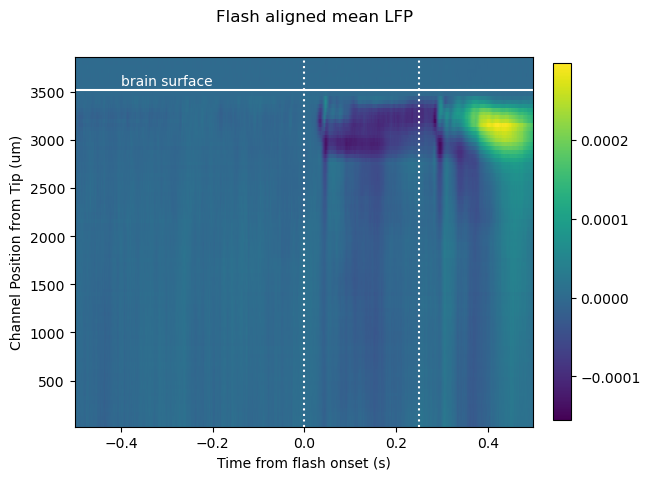

In [27]:
chans = session.get_channels()
lfp_chan_depths = [chans.loc[c]['probe_vertical_position'] for c in lfp.channel.values]

chans_in_brain = chans[(chans['probe_id']==1064735073)&(~chans['structure_acronym'].str.contains('root'))]
first_channel_in_brain_position = chans_in_brain['probe_vertical_position'].max()
fig, ax = plt.subplots()
fig.suptitle('Flash aligned mean LFP')
im = ax.pcolor(aligned_lfp.time_from_presentation_onset.values, lfp_chan_depths, aligned_lfp.mean(dim='presentation_id').data)
_ = plt.colorbar(im, fraction=0.036, pad=0.04)
_ = plt.xlabel('Time from flash onset (s)')
_ = plt.ylabel('Channel Position from Tip (um)')

ax.axvline(0, c='w', ls='dotted')
ax.axvline(0.25, c='w', ls='dotted')
ax.axhline(first_channel_in_brain_position, c='w')
ax.text(-0.4, first_channel_in_brain_position+50, 'brain surface', c='w')